In [70]:
from matplotlib import pyplot as plt
import datetime
import numpy as np
plt.style.use('ggplot')

In [2]:
def get_ts(line):
	tmp = line.split()
	dt = datetime.datetime.strptime(tmp[0], "%H:%M:%S.%f")
	return dt

def get_ms(line):
    tmp = line.split()
    return int(tmp[-1][:-2]) / 1000000.

def get_relatives(start, ts):
    delta = []
    for t in ts:
        delta.append((t - start).total_seconds())
    return delta

def parse_file(fname):
    f = open(fname, "r")
    binded = {}
    delete_ts = []
    added_ts = []
    latency = []
    insert_ts = []
    bind_ts = []
    fetch_ts = []
    fetch_count = []
    net_ts = []
    insert_str = "Insert/Update pod"
    delete_str = "Deleting pod"
    bind_str = "EmulatedPodToNodeBinder - Binding"
    fetch_str = "Fetchcount"
    added_str = "pod added"
    for line in f.readlines():
        if "system-pod" in line or "-resource-dummy" in line:
            continue
        if added_str in line:
            added_ts.append(get_ts(line))
            latency.append(get_ms(line))
            #if latency[-1] > 300:
            #    print(line)
        if insert_str in line:
            i1 = line.index(insert_str)
            tmp = line[i1+len(insert_str):].split(",")
            pid = tmp[0].lstrip().rstrip()
            name = tmp[1].lstrip().split()[0]
            insert_ts.append(get_ts(line))   
            net_ts.append(insert_ts[-1])      
        if delete_str in line:
            i1 = line.index(delete_str)
            tmp = line[i1+len(delete_str):].split(",")[0]
            pid = tmp.split(":")[1].lstrip().rstrip()
            name = tmp.split("(")[0].strip()
            delete_ts.append(get_ts(line))
            net_ts.append(delete_ts[-1])
        if bind_str in line:
            i1 = line.index(bind_str)
            tmp = line[i1+len(insert_str):].split(")")[0]
            pid = tmp.split("uid:")[1].strip()
            name = (tmp.split("(")[0]).split("/")[1]
            binded[pid] = name
            bind_ts.append(get_ts(line))
        if fetch_str in line:
            tmp = line.split()
            fetch_ts.append(get_ts(line))
            fetch_count.append(int(tmp[-1]))
    f.close()

    return insert_ts, added_ts, delete_ts, bind_ts, fetch_ts, fetch_count

In [3]:
def plot_trace(root, method, n, p):
    fname = "%s/%s-n%d-p%d.txt" % (root, method, n, p)
    insert_ts, added_ts, delete_ts, bind_ts, fetch_ts, fetch_count = parse_file(fname)

    start_ts = insert_ts[0]
    plt.figure(figsize=(12,8))
    plt.plot(get_relatives(start_ts, insert_ts), range(len(insert_ts)), label='insert', linestyle='--')
    plt.plot(get_relatives(start_ts, added_ts), range(len(added_ts)), label='added', linestyle='--')
    plt.plot(get_relatives(start_ts, delete_ts), range(len(delete_ts)), label='delete', linestyle='--')
    plt.plot(get_relatives(start_ts, bind_ts), range(len(bind_ts)), label='bind')
    plt.plot(get_relatives(start_ts, fetch_ts), fetch_count, label='fetchcount')
    plt.legend(fontsize=14, frameon=False)
    plt.ylim(0, 2500)
    plt.xlim(0,40)
    plt.xlabel("Time Elapsed (sec)", fontsize=18)
    plt.ylabel("# pods", fontsize=18)
    plt.title("%s(nodes:%d, anti-affinity:%d)" % (method, n, p), fontsize=18)
    plt.savefig("plots/n%d-p%d-%s.png" % (n, p, method), dpi=300)

In [4]:
scope_args = '"-n %d -f v2-cropped.txt -c 100 -m 200 -t 100 -s 100 -p %d -S"'
orig_args = '"-n %d -f v2-cropped.txt -c 100 -m 200 -t 100 -s 100 -p %d"'
template = './gradlew runBenchmark --args=%s | sed $"s,\x1b\\[[0-9;]*[a-zA-Z],,g" &> %s'

def gen_cmd(root, method, n, p, i):
    outfile = "%s/%s-n%d-p%d-%d.txt" % (root, method, n, p, i)
    if method == 'orig':
        args = orig_args % (n, p)
    else:
        args = scope_args % (n, p)
    cmd = template % (args, outfile)
    return cmd

In [14]:
def solver_latency(root, method, n, p, i):
    fname = "%s/%s-n%d-p%d-%d.txt" % (root, method, n, p, i)
    f = open(fname, "r")
    batch_str = "queries from a batch of"
    solver_str = "Solver has run successfully in"
    latency = []
    batch_size = []
    for line in f.readlines():
        if batch_str in line:
            tmp = line.split()
            batch_size.append(int(tmp[-5]))
        elif solver_str in line:
            tmp = line.split()
            ns = int(tmp[-3][:-3])
            latency.append(ns / 1000000.)
    return batch_size, latency[1:]

In [6]:
# Root directory of the log files 
root = "/Users/krong/Desktop/scope-traces"

In [89]:
# Generate all run commands 
root += "/logging"
f = open("scope_bench.sh", "w")
for method in ["scope"]:
    for n in [500, 5000, 50000]:
        for p in [0, 50, 100]:
            for i in [0]:
                cmd = gen_cmd(root, method, n, p, i)
                f.write('%s\n\n' % cmd)
f.close()

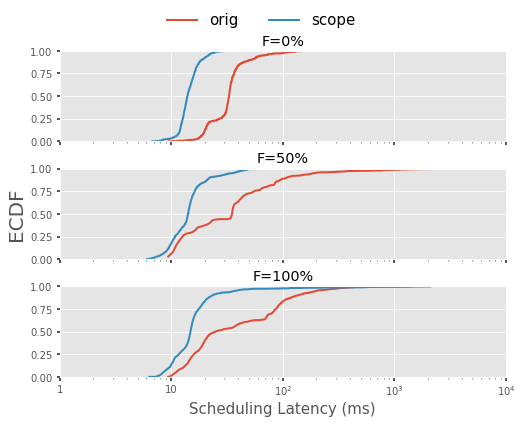

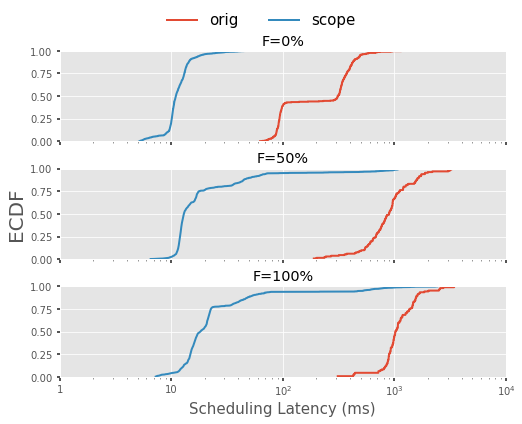

In [87]:
def get_cdf(data):
    count, bins_count = np.histogram(data, bins=10000)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    return bins_count, cdf


# Solver latency
for n in [500, 5000]:
    fig, axes = plt.subplots(3,1,figsize=(8, 6), sharex=True)
    plt.xscale("log")
    plt.xlim(1, 10000)
    axes[2].set_xticks([1, 10, 100, 1000, 10000])
    axes[2].set_xticklabels([1, 10, r"$10^2$", r"$10^3$", r"$10^4$"])
    plt.xlabel("Scheduling Latency (ms)", fontsize=15)
    axes[1].set_ylabel("ECDF", fontsize=20)
    for i, p in enumerate([0, 50, 100]):
        axes[i].set_title("F=%d" % p + "%")
        axes[i].set_yticks([0, 0.25, 0.5, 0.75, 1])
        axes[i].set_ylim(0, 1)
        axes[i].xaxis.set_tick_params(width=2)
        axes[i].yaxis.set_tick_params(width=2)
        for method in ["orig", "scope"]:
            latency = []
            for j in range(5):
                b, t = solver_latency(root, method, n, p, j)
                latency.extend(t)
            bins_count, cdf = get_cdf(latency)
            axes[i].plot(bins_count[1:], cdf, label=method,linewidth=2)
    
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', frameon=False, fontsize=15, ncol=2,)
    plt.subplots_adjust(hspace=0.3)
    plt.savefig("plots/n%d.pdf" % n, dpi=300, bbox_inches='tight')

TypeError: solver_latency() missing 1 required positional argument: 'i'

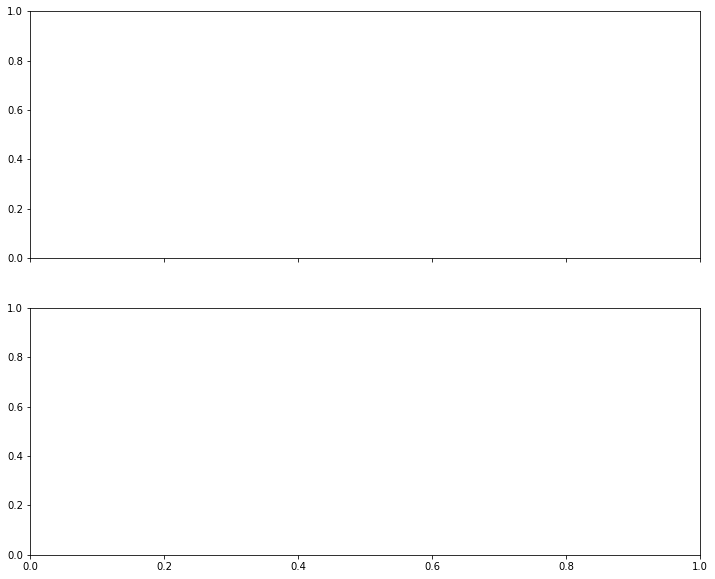

In [44]:
# Solver latency
fig,axes = plt.subplots(2,1,figsize=(12, 10), sharex=True)
for i, method in enumerate(["orig","scope"]):
    batch = []
    latency = []
    ticks = []
    for n in [500, 5000, 50000]:
        for p in [0, 50, 100]:
            ticks.append("%d,%d" % (n,p))
            b, t = solver_latency(root, method, n, p)
            batch.append(np.average(b))
            latency.append(np.average(t))
    x = list(range(len(latency)))
    axes[0].bar(np.add(x,0.3*i), latency, width=0.3, label=method)
    axes[1].bar(np.add(x,0.3*i), batch, width=0.3, label=method)
pos = np.add(x,0.3/2)
axes[0].set_ylabel("Avg solver latency (ms)", fontsize=20)
axes[1].set_ylabel("Avg batch size", fontsize=20)
plt.xticks(pos, ticks,fontsize=12)
axes[0].set_yscale("log")
axes[0].legend(frameon=False, fontsize=20, ncol=2, bbox_to_anchor=(0.5, 1.05))
plt.show()

avg: 0.180238, min: 0.052305, max: 1.318057, std: 0.122911
avg: 6.306807, min: 0.059922, max: 263.266260, std: 22.300554
avg: 4.444204, min: 0.068205, max: 189.024293, std: 16.307371
avg: 0.129588, min: 0.043790, max: 1.140635, std: 0.062613
avg: 10.055203, min: 0.061691, max: 472.682320, std: 44.334879
avg: 14.743206, min: 0.558088, max: 504.723744, std: 66.669277
avg: 0.402390, min: 0.033858, max: 90.355607, std: 5.041022
avg: 2.974689, min: 0.036129, max: 139.746694, std: 5.329379
avg: 6.124647, min: 0.616979, max: 478.579749, std: 31.216304
avg: 0.167912, min: 0.056341, max: 1.086920, std: 0.086587
avg: 4.115150, min: 0.072402, max: 177.261479, std: 12.949484
avg: 5.578646, min: 0.091598, max: 183.863202, std: 15.950964
avg: 0.150663, min: 0.031003, max: 1.802366, std: 0.138070
avg: 22.151519, min: 0.539910, max: 181.001854, std: 27.416661
avg: 21.686419, min: 0.540904, max: 348.843212, std: 36.013754
avg: 0.135710, min: 0.034078, max: 1.792060, std: 0.080647
avg: 21.762051, min: 0

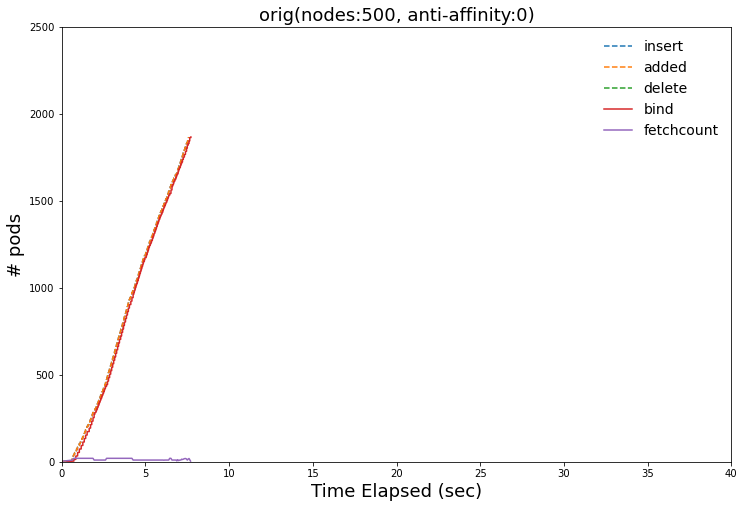

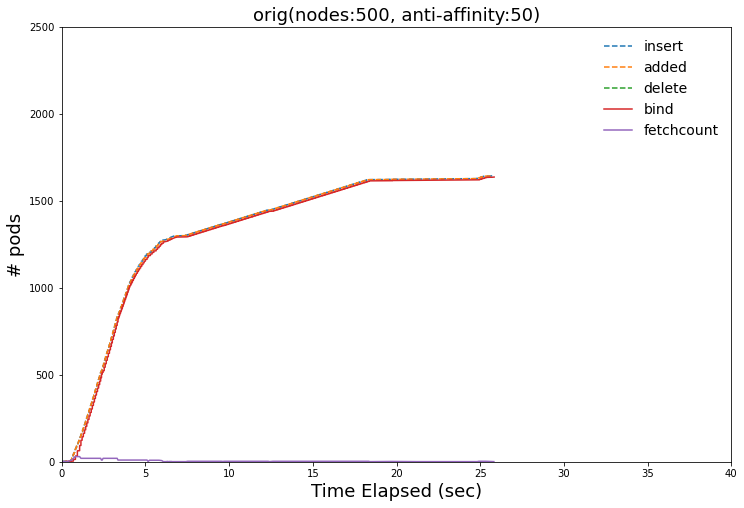

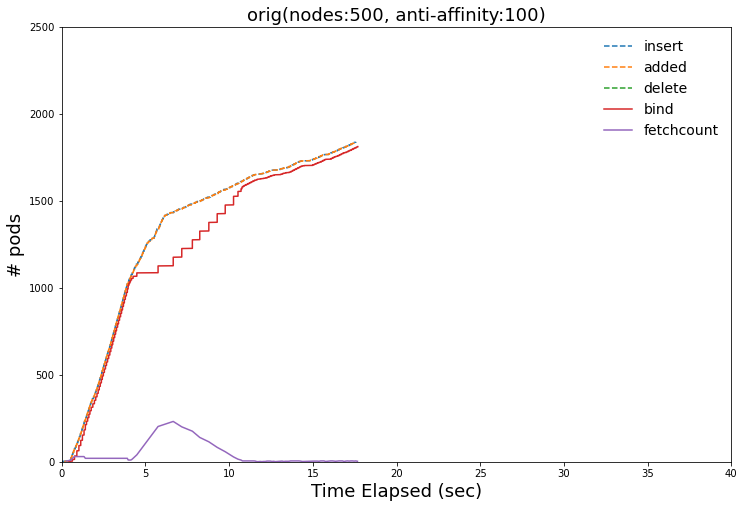

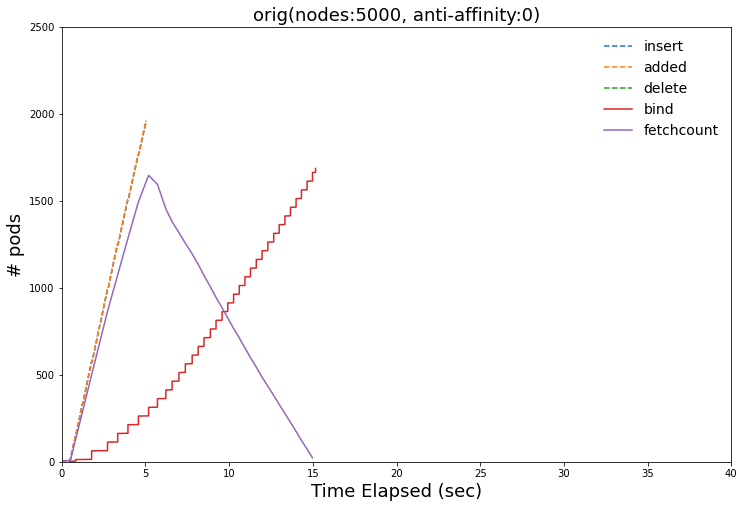

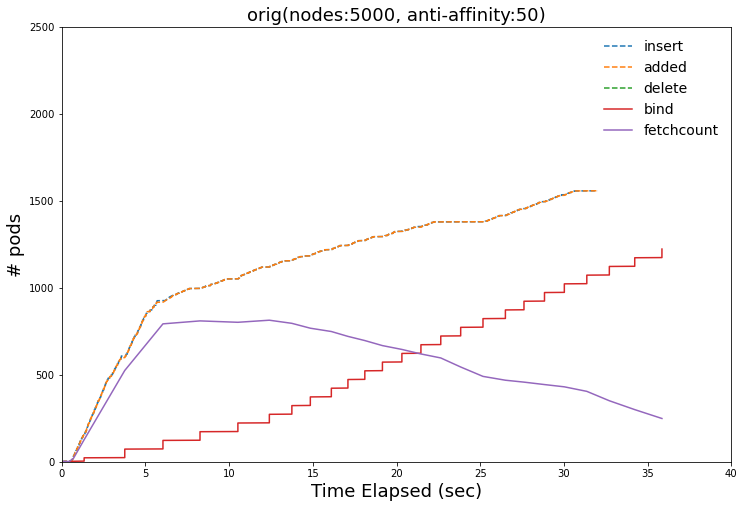

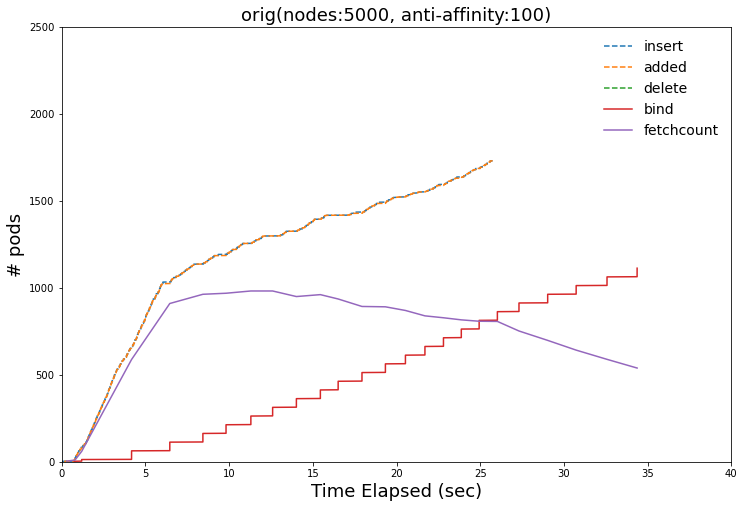

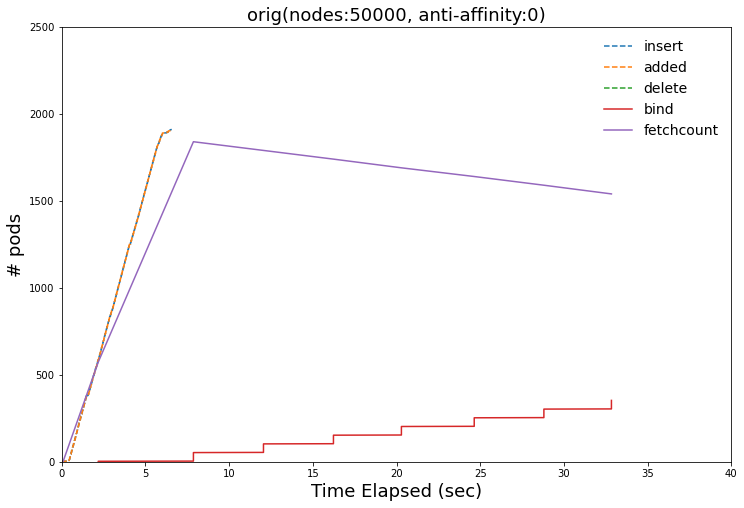

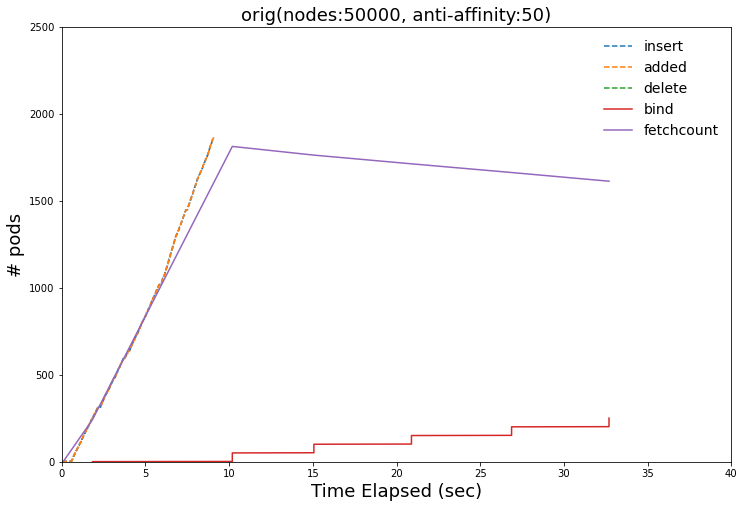

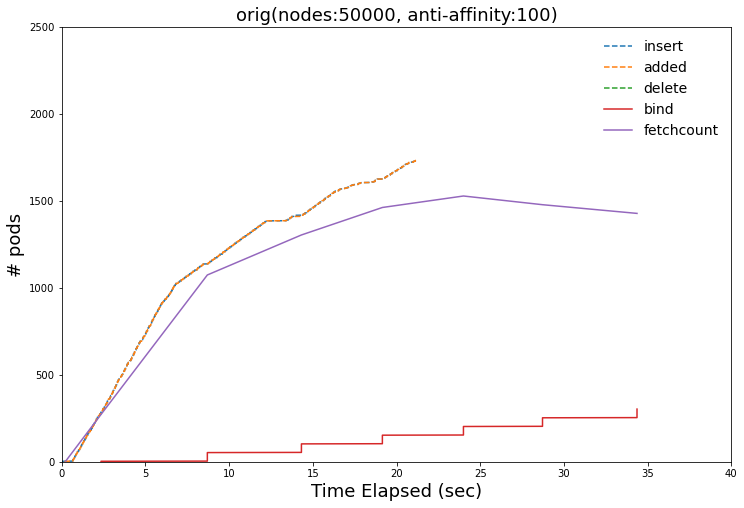

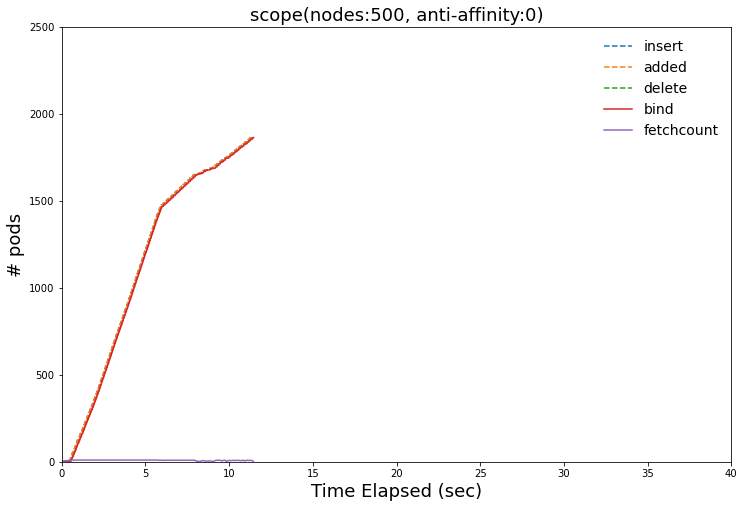

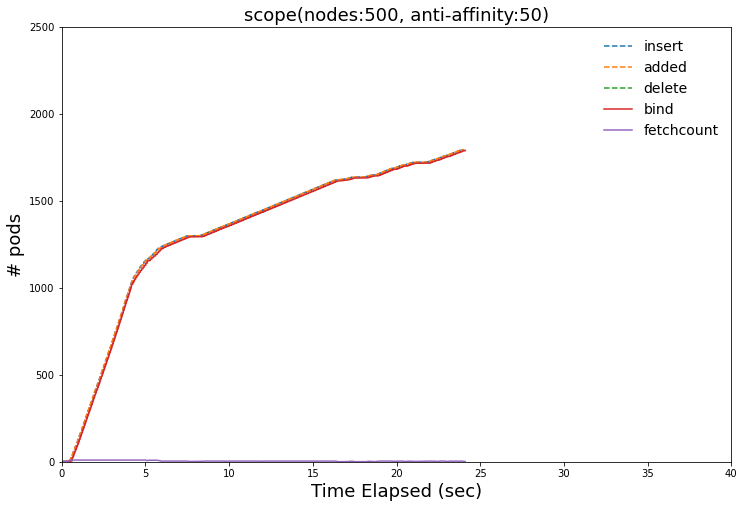

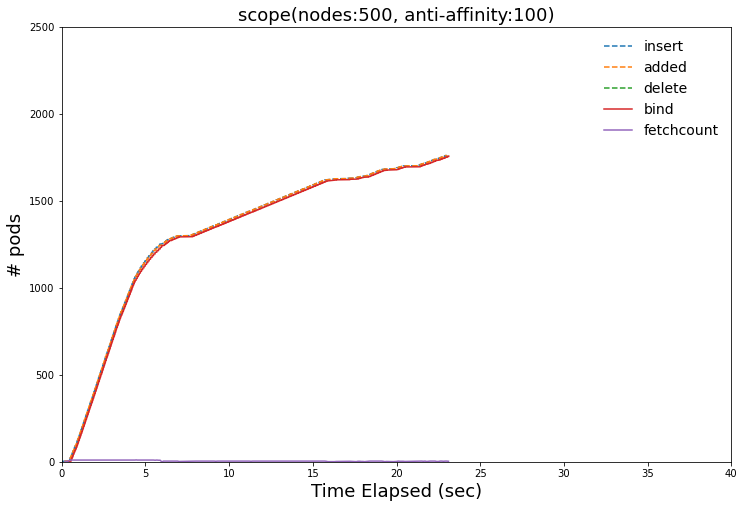

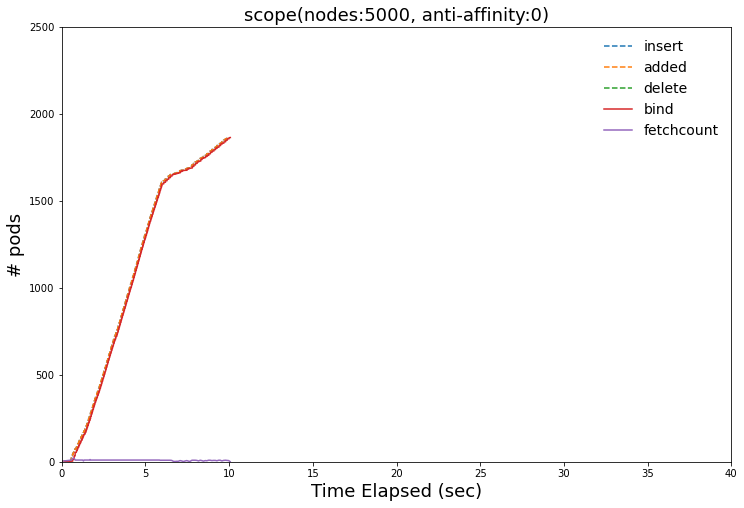

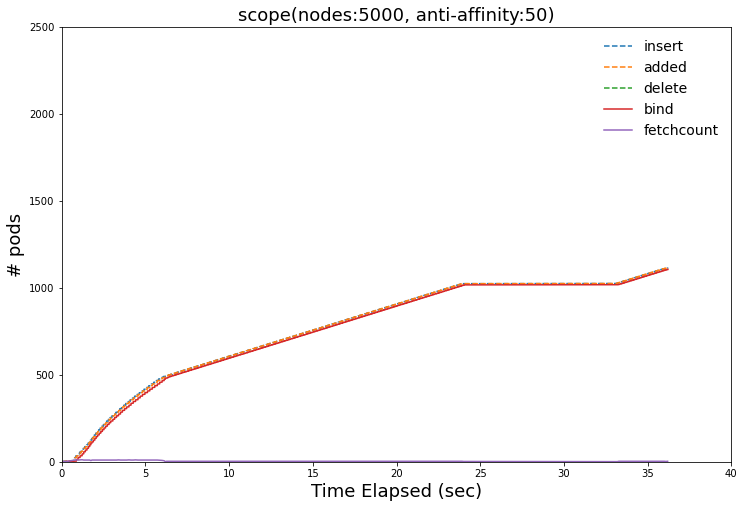

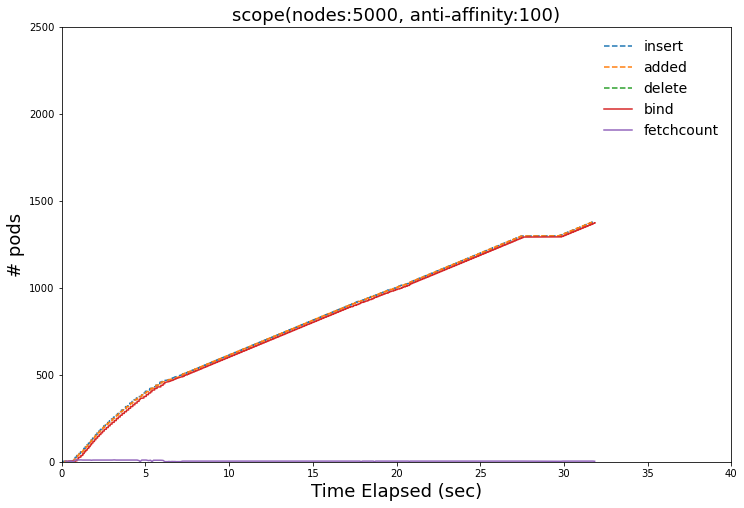

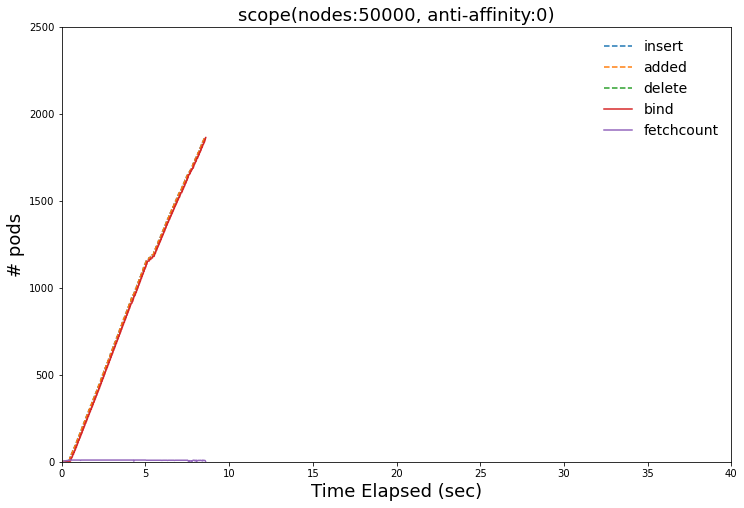

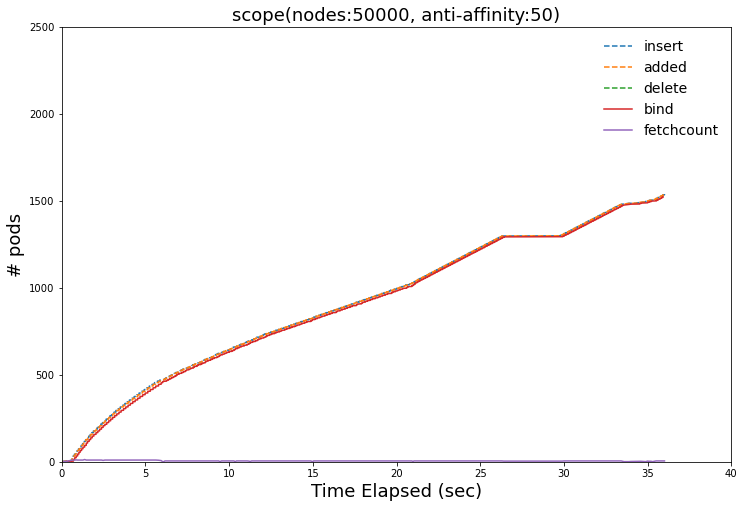

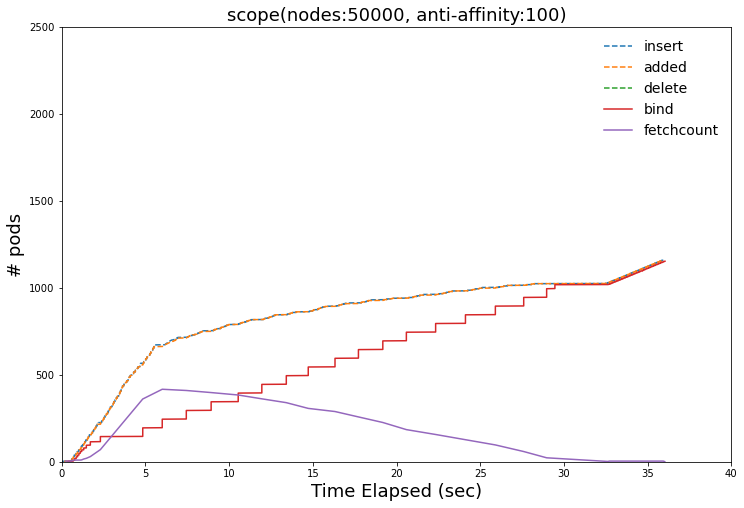

In [60]:
# Plot traces
for method in ["orig","scope"]:
    for n in [500, 5000, 50000]:
        for p in [0, 50, 100]:
            plot_trace(root, method, n, p)